INTEGRANTES:

- Edwin Montenegro
- Galo Travez

# LABORATORIO 5
#OBJETIVO

El objetivo de este taller es construir y entrenar un modelo LSTM (Long Short-Term Memory) utilizando PyTorch Lightning para la clasificación de emociones a partir de texto. Además de utilizar técnicas convencionales, se decidió experimentar con PyTorch Lightning debido a sus ventajas en la organización del código y la gestión eficiente del proceso de entrenamiento. Es importante señalar que cada modelo requiere un tiempo considerable de entrenamiento y recursos computacionales, lo que  nos limitó la comparativa a la implementación  con otros modelos.

In [ ]:
import time
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBar
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

Este bloque de código:

   1. **Divide el conjunto de datos**: Se separan las frases y sus etiquetas en dos conjuntos: uno para entrenamiento (80%) y otro para pruebas (20%), manteniendo la proporción de las clases de sentimiento. Esto asegura que la evaluación del modelo sea precisa.

In [ ]:
# Cargar el dataset
df = pd.read_csv('/home/emontenegrob/Labs_NLP/data/train.tsv', sep='\t')

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(df['Phrase'], df['Sentiment'],
                                                    test_size=0.2,
                                                    stratify=df['Sentiment'],
                                                    random_state=13)


In [ ]:
df.head(20)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB



# Preprocesamiento de Datos:
- Carga y preparación del conjunto de datos de frases con etiquetas de emociones.
- Tokenización de las frases en secuencias numéricas que puedan ser procesadas por la red LSTM.
- Manejo de secuencias de longitud variable mediante padding para que todas las secuencias tengan la misma longitud.

In [ ]:
# Restablecer los índices
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Configuración de la tokenización
MAX_NUM_WORDS = 10000  # Número máximo de palabras en el vocabulario
MAX_SEQ_LENGTH = 100   # Longitud máxima de la secuencia (palabras por frase)


In [ ]:
# Inicializar el tokenizador
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)  # Crear vocabulario basado en el conjunto de entrenamiento

# Convertir frases en secuencias de índices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding para tener secuencias de longitud fija
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LENGTH, padding='post')



In [ ]:
# Dataset personalizado para textos y etiquetas
class EmotionDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]



# Definición y Entrenamiento del Modelo LSTM
- Definir una red LSTM utilizando PyTorch para procesar las secuencias de texto y aprender a predecir la etiqueta de emoción.
- Entrenar el modelo utilizando PyTorch Lightning para facilitar la organización del código y optimizar el entrenamiento.
- Monitorear el rendimiento del modelo durante el entrenamiento utilizando métricas como la precisión (accuracy) y la pérdida (loss).

# Descripcion de la arquitectura
La LSTM recibe como entrada una secuencia de vectores de embedding y, a través de sus celdas de memoria, genera una secuencia de salidas, donde cada salida representa el estado oculto en cada paso temporal.

1. Capa de Embeddings:
Convierte palabras en vectores densos (dimensión: embedding_dim).
2. Capa LSTM:
Procesa la secuencia de embeddings y mantiene una memoria a lo largo de la secuencia.
Número de unidades ocultas: hidden_size.
Número de capas LSTM: 2.
3. Capa Lineal:
Mapea el estado final de la LSTM a las clases de salida.
4. Capa Softmax:
Convierte las salidas a probabilidades logarítmicas para cada clase.

In [ ]:
# Modelo LSTM simple
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=2, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, hidden):
        embeds = self.embedding(input_ids)
        output, hidden = self.lstm(embeds, hidden)
        output = self.fc(output[:, -1, :])  # Usamos la última salida del LSTM
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size, device):
        # Inicializar el estado oculto y el estado de celda con el tamaño adecuado
        return (torch.zeros(2, batch_size, self.hidden_size).to(device),
                torch.zeros(2, batch_size, self.hidden_size).to(device))


In [ ]:
# Lightning Module para el entrenamiento y evaluación
class LightningLSTM(pl.LightningModule):
    def __init__(self, model, lr):
        super(LightningLSTM, self).__init__()
        self.model = model
        self.lr = lr
        self.loss_fn = nn.NLLLoss()

    def forward(self, x, hidden):
        return self.model(x, hidden)

    def training_step(self, batch, batch_idx):
        input_ids, labels = batch
        hidden = self.model.initHidden(input_ids.size(0), self.device)
        output, hidden = self(input_ids, hidden)
        loss = self.loss_fn(output, labels)
        acc = (output.argmax(dim=1) == labels).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, labels = batch
        hidden = self.model.initHidden(input_ids.size(0), self.device)
        output, hidden = self(input_ids, hidden)
        loss = self.loss_fn(output, labels)
        acc = (output.argmax(dim=1) == labels).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return loss

    # Agregar test_step para evaluación en el conjunto de prueba
    def test_step(self, batch, batch_idx):
        input_ids, labels = batch
        hidden = self.model.initHidden(input_ids.size(0), self.device)
        output, hidden = self(input_ids, hidden)
        loss = self.loss_fn(output, labels)
        acc = (output.argmax(dim=1) == labels).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'test_loss': loss, 'test_acc': acc}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)



In [ ]:
# DataModule para manejar los datos
class EmotionDataModule(pl.LightningDataModule):
    def __init__(self, X_train_pad, X_test_pad, y_train, y_test, batch_size):
        super().__init__()
        self.X_train_pad = X_train_pad
        self.X_test_pad = X_test_pad
        self.y_train = y_train
        self.y_test = y_test
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = EmotionDataset(self.X_train_pad, self.y_train)
        self.test_dataset = EmotionDataset(self.X_test_pad, self.y_test)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)



In [ ]:

# Inicialización del modelo LSTM y el DataModule
vocab_size = MAX_NUM_WORDS
embedding_dim = 128
hidden_size = 128
num_classes = 5  # 5 clases de emociones (0 a 4)
batch_size = 32
learning_rate = 0.001
dropout_prob = 0.2

In [ ]:
# Crear el modelo LSTM
lstm_model = LSTMModel(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_size=hidden_size, output_size=num_classes, dropout_prob=dropout_prob)

# Inicialización del modulo lightning
lightning_model = LightningLSTM(lstm_model, lr=learning_rate)

# Inicialización del modulo de datos
data_module = EmotionDataModule(X_train_pad, X_test_pad, y_train, y_test, batch_size)

# Callbacks y logger
callback_check = ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc")
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3)
callback_tqdm = RichProgressBar(leave=True)
logger = CSVLogger(save_dir="logs/", name="lstm_emotions")

# Inicializar el entrenador con los callbacks
trainer = pl.Trainer(max_epochs=10,
                     callbacks=[callback_check, callback_tqdm, callback_early_stopping],
                     accelerator="auto",
                     devices="auto",
                     logger=logger,
                     log_every_n_steps=100)



INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Entrenamiento
start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)
runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ LSTMModel │  1.5 M │ train │
│ 1 │ loss_fn │ NLLLoss   │      0 │ train │
└───┴─────────┴───────────┴────────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 6                                                                                           
Modules in eval mode: 0

Output()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is 
incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Output()

Output()

Output()

Output()

Output()

Output()

Tiempo de entrenamiento en minutos: 13.23


In [ ]:
# Evaluación del modelo en el conjunto de prueba con el mejor checkpoint
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/lstm_emotions/version_0/checkpoints/epoch=0-step=3902.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/lstm_emotions/version_0/checkpoints/epoch=0-step=3902.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.509964108467102     │
│         test_loss         │    1.2845698595046997     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.2845698595046997, 'test_acc': 0.509964108467102}]

In [ ]:
# Obtener predicciones y etiquetas verdaderas
all_preds = []
all_labels = []

for batch in data_module.test_dataloader():
    input_ids, labels = batch
    hidden = lstm_model.initHidden(input_ids.size(0), device=input_ids.device)
    output, _ = lstm_model(input_ids, hidden)
    all_preds.extend(output.argmax(dim=1).cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Calcular F1-score ponderado
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1 Score: {weighted_f1}')

Weighted F1 Score: 0.34446302022914427


# Interpretación de Weighted F1 Score
- Es una métrica que toma en cuenta las clases desbalanceadas, y este valor refleja mejor el rendimiento del modelo que la precisión general.
- Un F1 ponderado de 0.344 es bastante bajo y nos indica que el modelo no está haciendo buenas predicciones en todas las clases.

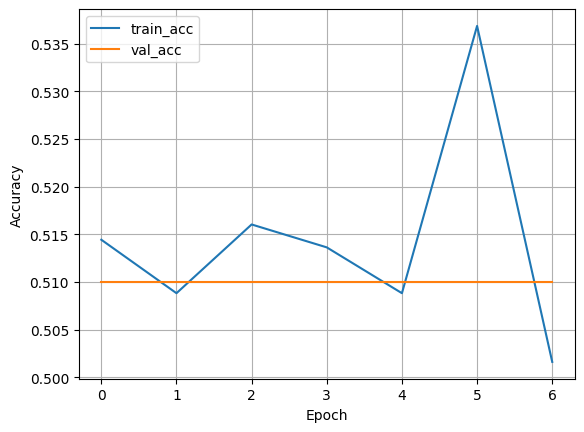

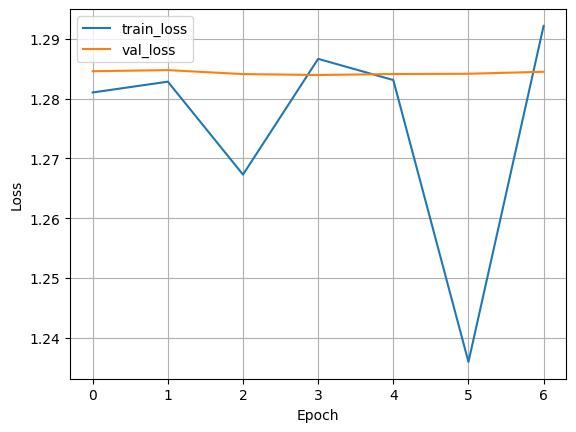

In [ ]:
# Análisis de métricas y gráficas
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)

# Manejar la ausencia de columnas
if 'train_acc' in df_metrics.columns and 'val_acc' in df_metrics.columns:
    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy"
    )
else:
    print("Las columnas 'train_acc' o 'val_acc' no están en el DataFrame.")

df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

plt.show()

#  Interpretación de las gràficas
Esta precisión puede parecer aceptable, pero al observar la matriz de confusión, vemos que el modelo solo está prediciendo la clase 2 para todas las muestras. Dado que la clase 2 puede ser la más común en tu conjunto de datos, simplemente predecir siempre esa clase podría resultar en una precisión engañosamente alta.
 Por otra parte el valor de la pérdida es moderadamente alto. Esto, junto con la matriz de confusión, sugiere que el modelo no está haciendo buenas predicciones, aunque la pérdida no es suficiente para captar los problemas de las predicciones siempre siendo la clase 2.

# Crear la matriz de confusión

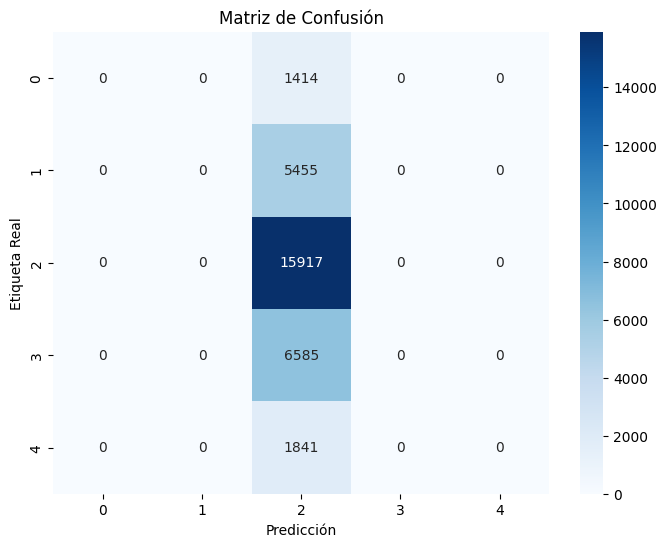

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

# Crear la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Visualizar la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

#  Interpretación de matriz de confusión
- La matriz de confusión muestra que todas las predicciones del modelo son de la clase 2.
- Independientemente de la etiqueta real, el modelo predice siempre la clase 2.
Esto indica que el modelo está fuertemente sesgado hacia la clase 2 y no logra distinguir correctamente entre las demás clases.

# MODELO ENTRENADO CON 3 CATEGORIAS
-  MODELO ENTREDADO  CON LSTM


In [1]:
import time
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBar
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
# Cargar el dataset
df = pd.read_csv('/home/emontenegrob/Labs_NLP/data/train.tsv', sep='\t')


In [3]:
# Filtrar las clases 1 y 3
df_filtered = df[df['Sentiment'].isin([0, 2, 4])]

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(df_filtered['Phrase'], df_filtered['Sentiment'],
                                                    test_size=0.2,
                                                    stratify=df_filtered['Sentiment'],
                                                    random_state=13)


In [4]:
# Restablecer los índices
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
# Reasignar etiquetas: 0 -> 0, 2 -> 1, 4 -> 2
y_train = y_train.map({0: 0, 2: 1, 4: 2})
y_test = y_test.map({0: 0, 2: 1, 4: 2})

In [6]:
# Configuración de la tokenización
MAX_NUM_WORDS = 10000  # Número máximo de palabras en el vocabulario
MAX_SEQ_LENGTH = 100   # Longitud máxima de la secuencia (palabras por frase)


In [7]:
# Inicializar el tokenizador
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)  # Crear vocabulario basado en el conjunto de entrenamiento

# Convertir frases en secuencias de índices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding para tener secuencias de longitud fija
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LENGTH, padding='post')


In [8]:
# Dataset personalizado para textos y etiquetas
class EmotionDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


In [9]:
# Modelo LSTM simple
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=2, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, hidden):
        embeds = self.embedding(input_ids)
        output, hidden = self.lstm(embeds, hidden)
        output = self.fc(output[:, -1, :])  # Usamos la última salida del LSTM
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size, device):
        # Inicializar el estado oculto y el estado de celda con el tamaño adecuado
        return (torch.zeros(2, batch_size, self.hidden_size).to(device),
                torch.zeros(2, batch_size, self.hidden_size).to(device))


In [10]:
# Lightning Module para el entrenamiento y evaluación
class LightningLSTM(pl.LightningModule):
    def __init__(self, model, lr):
        super(LightningLSTM, self).__init__()
        self.model = model
        self.lr = lr
        self.loss_fn = nn.NLLLoss()

    def forward(self, x, hidden):
        return self.model(x, hidden)

    def training_step(self, batch, batch_idx):
        input_ids, labels = batch
        hidden = self.model.initHidden(input_ids.size(0), self.device)
        output, hidden = self(input_ids, hidden)
        loss = self.loss_fn(output, labels)
        acc = (output.argmax(dim=1) == labels).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, labels = batch
        hidden = self.model.initHidden(input_ids.size(0), self.device)
        output, hidden = self(input_ids, hidden)
        loss = self.loss_fn(output, labels)
        acc = (output.argmax(dim=1) == labels).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return loss

    # Agregar test_step para evaluación en el conjunto de prueba
    def test_step(self, batch, batch_idx):
        input_ids, labels = batch
        hidden = self.model.initHidden(input_ids.size(0), self.device)
        output, hidden = self(input_ids, hidden)
        loss = self.loss_fn(output, labels)
        acc = (output.argmax(dim=1) == labels).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'test_loss': loss, 'test_acc': acc}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [11]:
# DataModule para manejar los datos
class EmotionDataModule(pl.LightningDataModule):
    def __init__(self, X_train_pad, X_test_pad, y_train, y_test, batch_size):
        super().__init__()
        self.X_train_pad = X_train_pad
        self.X_test_pad = X_test_pad
        self.y_train = y_train
        self.y_test = y_test
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = EmotionDataset(self.X_train_pad, self.y_train)
        self.test_dataset = EmotionDataset(self.X_test_pad, self.y_test)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)



In [12]:
# Inicialización del modelo LSTM y el DataModule
vocab_size = MAX_NUM_WORDS
embedding_dim = 128
hidden_size = 128
num_classes = 3  # Cambiado a 3 clases (0, 1, 2)
batch_size = 32
learning_rate = 0.001
dropout_prob = 0.2

In [14]:
# Crear el modelo LSTM
lstm_model = LSTMModel(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_size=hidden_size, output_size=num_classes, dropout_prob=dropout_prob)

# Inicialización del modulo lightning
lightning_model = LightningLSTM(lstm_model, lr=learning_rate)

# Inicialización del modulo de datos
data_module = EmotionDataModule(X_train_pad, X_test_pad, y_train, y_test, batch_size)

# Callbacks y logger
callback_check = ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc")
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3)
callback_tqdm = RichProgressBar(leave=True)
logger = CSVLogger(save_dir="logs3/", name="lstm_emotions")

# Inicializar el entrenador con los callbacks
trainer = pl.Trainer(max_epochs=20,
                     callbacks=[callback_check, callback_tqdm, callback_early_stopping],
                     accelerator="auto",
                     devices="auto",
                     logger=logger,
                     log_every_n_steps=100)



INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [15]:
# Entrenamiento
start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)
runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

# Evaluación del modelo en el conjunto de prueba con el mejor checkpoint
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ LSTMModel │  1.5 M │ train │
│ 1 │ loss_fn │ NLLLoss   │      0 │ train │
└───┴─────────┴───────────┴────────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 6                                                                                           
Modules in eval mode: 0

Output()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is 
incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Output()

Output()

Output()

Output()

Output()

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs3/lstm_emotions/version_0/checkpoints/epoch=0-step=2397.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs3/lstm_emotions/version_0/checkpoints/epoch=0-step=2397.ckpt


Tiempo de entrenamiento en minutos: 6.14


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8301690220832825     │
│         test_loss         │    0.5735800862312317     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5735800862312317, 'test_acc': 0.8301690220832825}]

In [16]:
# Obtener predicciones y etiquetas verdaderas
all_preds = []
all_labels = []

for batch in data_module.test_dataloader():
    input_ids, labels = batch
    hidden = lstm_model.initHidden(input_ids.size(0), device=input_ids.device)
    output, _ = lstm_model(input_ids, hidden)
    all_preds.extend(output.argmax(dim=1).cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Calcular F1-score ponderado
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1 Score: {weighted_f1}')

Weighted F1 Score: 0.7531332505442607


<Axes: xlabel='Epoch', ylabel='Loss'>

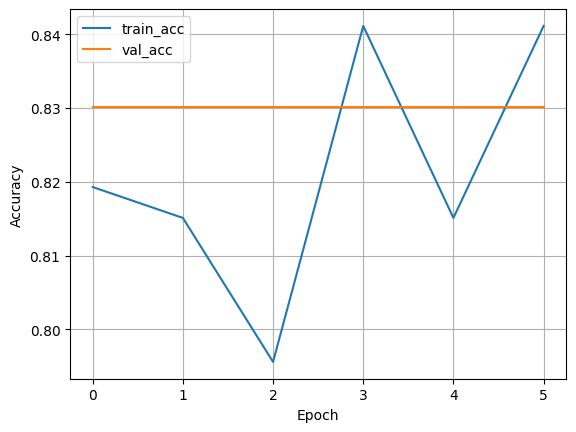

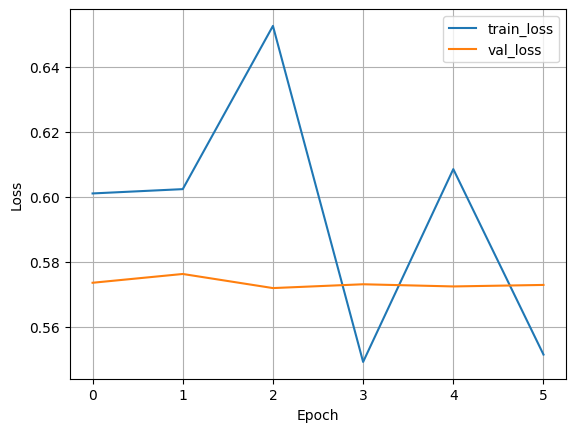

In [17]:
# Análisis de métricas y gráficas
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)

# Manejar la ausencia de columnas
if 'train_acc' in df_metrics.columns and 'val_acc' in df_metrics.columns:
    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy"
    )
else:
    print("Las columnas 'train_acc' o 'val_acc' no están en el DataFrame.")

df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

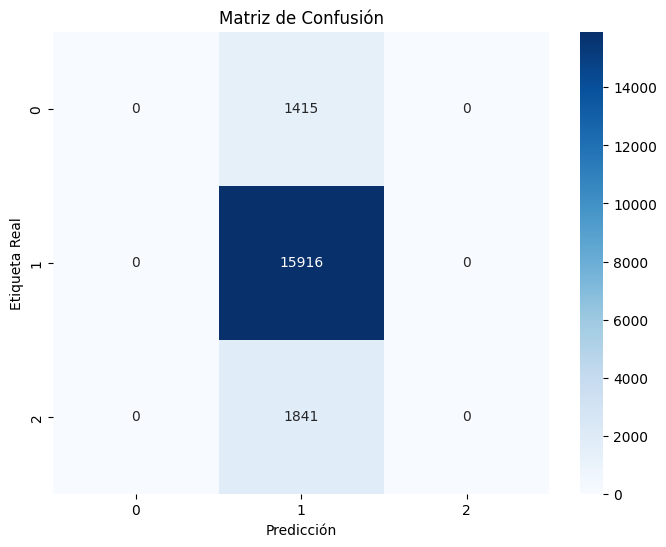

In [18]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

# Crear la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Visualizar la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# MODELO ENTRENADO CON GRU

In [19]:
import time
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBar
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [20]:
# Cargar el dataset
df = pd.read_csv('/home/emontenegrob/Labs_NLP/data/train.tsv', sep='\t')

# Filtrar las clases 1 y 3
df_filtered = df[df['Sentiment'].isin([0, 2, 4])]

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(df_filtered['Phrase'], df_filtered['Sentiment'],
                                                    test_size=0.2,
                                                    stratify=df_filtered['Sentiment'],
                                                    random_state=13)


In [21]:
# Restablecer los índices
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Reasignar etiquetas: 0 -> 0, 2 -> 1, 4 -> 2
y_train = y_train.map({0: 0, 2: 1, 4: 2})
y_test = y_test.map({0: 0, 2: 1, 4: 2})

# Configuración de la tokenización
MAX_NUM_WORDS = 10000  # Número máximo de palabras en el vocabulario
MAX_SEQ_LENGTH = 100   # Longitud máxima de la secuencia (palabras por frase)


In [22]:
# Inicializar el tokenizador
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)  # Crear vocabulario basado en el conjunto de entrenamiento

# Convertir frases en secuencias de índices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding para tener secuencias de longitud fija
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LENGTH, padding='post')


# Dataset personalizado para textos y etiquetas

In [23]:
# Dataset personalizado para textos y etiquetas
class EmotionDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]


# Modelo GRU

In [24]:
# Modelo GRU
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, dropout_prob):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=2, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, hidden):
        embeds = self.embedding(input_ids)
        output, hidden = self.gru(embeds, hidden)
        output = self.fc(output[:, -1, :])  # Usamos la última salida de la GRU
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size, device):
        # Inicializar el estado oculto con el tamaño adecuado
        return torch.zeros(2, batch_size, self.hidden_size).to(device)


In [25]:
# Lightning Module para el entrenamiento y evaluación
class LightningGRU(pl.LightningModule):
    def __init__(self, model, lr):
        super(LightningGRU, self).__init__()
        self.model = model
        self.lr = lr
        self.loss_fn = nn.NLLLoss()

    def forward(self, x, hidden):
        return self.model(x, hidden)

    def training_step(self, batch, batch_idx):
        input_ids, labels = batch
        hidden = self.model.initHidden(input_ids.size(0), self.device)
        output, hidden = self(input_ids, hidden)
        loss = self.loss_fn(output, labels)
        acc = (output.argmax(dim=1) == labels).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, labels = batch
        hidden = self.model.initHidden(input_ids.size(0), self.device)
        output, hidden = self(input_ids, hidden)
        loss = self.loss_fn(output, labels)
        acc = (output.argmax(dim=1) == labels).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return loss

    # Agregar test_step para evaluación en el conjunto de prueba
    def test_step(self, batch, batch_idx):
        input_ids, labels = batch
        hidden = self.model.initHidden(input_ids.size(0), self.device)
        output, hidden = self(input_ids, hidden)
        loss = self.loss_fn(output, labels)
        acc = (output.argmax(dim=1) == labels).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'test_loss': loss, 'test_acc': acc}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [26]:
# DataModule para manejar los datos
class EmotionDataModule(pl.LightningDataModule):
    def __init__(self, X_train_pad, X_test_pad, y_train, y_test, batch_size):
        super().__init__()
        self.X_train_pad = X_train_pad
        self.X_test_pad = X_test_pad
        self.y_train = y_train
        self.y_test = y_test
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = EmotionDataset(self.X_train_pad, self.y_train)
        self.test_dataset = EmotionDataset(self.X_test_pad, self.y_test)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)



In [27]:
# Inicialización del modelo GRU y el DataModule
vocab_size = MAX_NUM_WORDS
embedding_dim = 128
hidden_size = 128
num_classes = 3  # 3 clases (0, 1, 2)
batch_size = 32
learning_rate = 0.001
dropout_prob = 0.2

In [28]:
# Crear el modelo GRU
gru_model = GRUModel(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_size=hidden_size, output_size=num_classes, dropout_prob=dropout_prob)

# Inicialización del modulo lightning
lightning_model = LightningGRU(gru_model, lr=learning_rate)

# Inicialización del modulo de datos
data_module = EmotionDataModule(X_train_pad, X_test_pad, y_train, y_test, batch_size)

# Callbacks y logger
callback_check = ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc")
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3)
callback_tqdm = RichProgressBar(leave=True)
logger = CSVLogger(save_dir="logs4/", name="gru_emotions")

# Inicializar el entrenador con los callbacks
trainer = pl.Trainer(max_epochs=10,
                     callbacks=[callback_check, callback_tqdm, callback_early_stopping],
                     accelerator="auto",
                     devices="auto",
                     logger=logger,
                     log_every_n_steps=100)


INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [29]:
# Entrenamiento
start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)
runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GRUModel │  1.5 M │ train │
│ 1 │ loss_fn │ NLLLoss  │      0 │ train │
└───┴─────────┴──────────┴────────┴───────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 6                                                                                           
Modules in eval mode: 0

Output()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is 
incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Output()

Output()

Output()

Output()

Output()

Tiempo de entrenamiento en minutos: 6.04


In [30]:
# Evaluación del modelo en el conjunto de prueba con el mejor checkpoint
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs4/gru_emotions/version_0/checkpoints/epoch=2-step=7191.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs4/gru_emotions/version_0/checkpoints/epoch=2-step=7191.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9191529154777527     │
│         test_loss         │    0.25186657905578613    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.25186657905578613, 'test_acc': 0.9191529154777527}]

In [31]:
# Obtener predicciones y etiquetas verdaderas
all_preds = []
all_labels = []

for batch in data_module.test_dataloader():
    input_ids, labels = batch
    hidden = gru_model.initHidden(input_ids.size(0), device=input_ids.device)
    output, _ = gru_model(input_ids, hidden)
    all_preds.extend(output.argmax(dim=1).cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Calcular F1-score ponderado
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1 Score: {weighted_f1}')

Weighted F1 Score: 0.9160734953157603


<Axes: xlabel='Epoch', ylabel='Loss'>

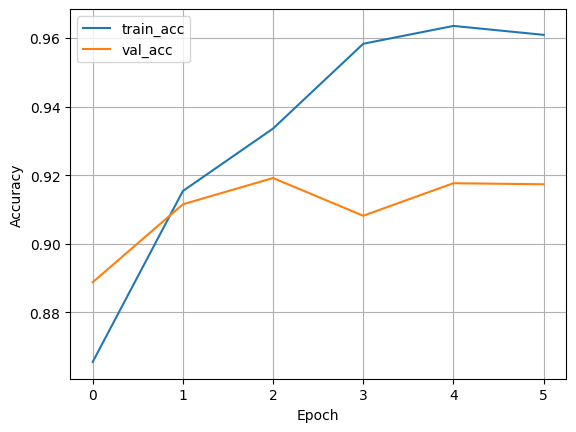

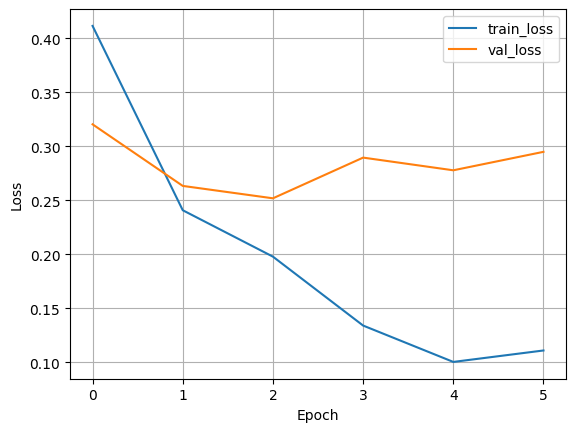

In [32]:
# Análisis de métricas y gráficas
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)

# Manejar la ausencia de columnas
if 'train_acc' in df_metrics.columns and 'val_acc' in df_metrics.columns:
    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy"
    )
else:
    print("Las columnas 'train_acc' o 'val_acc' no están en el DataFrame.")

df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

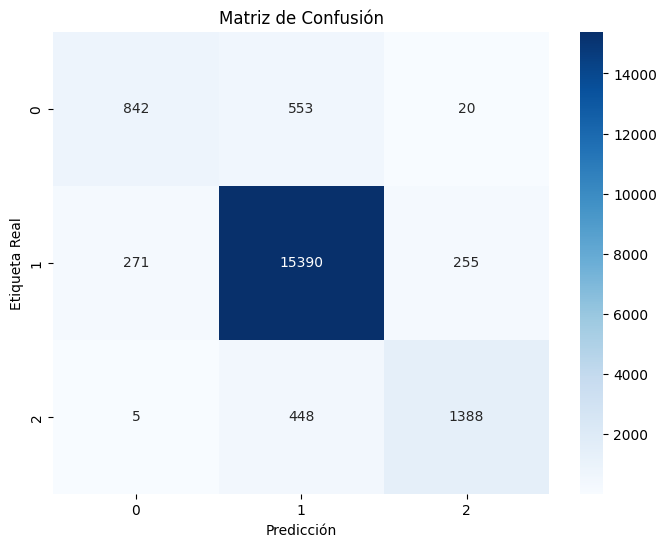

In [33]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

# Crear la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Visualizar la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()